# Deep Q-Learning (DQN) in Reinforcement Learning

This notebook demonstrates Deep Q-Learning (DQN), a breakthrough algorithm that combines Q-learning with deep neural networks to solve complex reinforcement learning problems with high-dimensional state spaces.

## Learning Objectives
By the end of this notebook, you will understand:
- How neural networks can approximate Q-functions
- The challenges of combining Q-learning with function approximation
- Experience replay and its role in stabilizing learning
- Target networks and their importance for stable training
- How to implement and train a DQN agent
- The advantages and limitations of deep Q-learning

## Key Concepts
- **Function Approximation**: Using neural networks to approximate Q-functions
- **Experience Replay**: Storing and sampling from past experiences
- **Target Networks**: Using separate networks for stable learning targets
- **Deep Q-Network (DQN)**: The complete algorithm combining these techniques
- **Convergence Challenges**: Why naive approaches fail and how DQN addresses them

---

<a href="https://colab.research.google.com/github/xhxuciedu/CS175/blob/master/notebooks/deep_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Setup and Installation

**Note:** This notebook requires PyTorch for neural network implementation. Make sure you have the appropriate runtime type selected.


In [136]:
# %%capture
# %pip install torch torchvision torchaudio
# %pip install 'gymnasium[box2d]'
# %pip install matplotlib numpy



In [137]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque, namedtuple
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## Understanding Deep Q-Learning

Deep Q-Learning addresses a fundamental limitation of traditional Q-learning: **the curse of dimensionality**. When state spaces become large or continuous, maintaining a Q-table becomes impossible.

### The Problem with Traditional Q-Learning

Traditional Q-learning maintains a table $Q(s,a)$ for every state-action pair. This works well for:
- Small, discrete state spaces
- Tabular environments like FrozenLake

But fails for:
- High-dimensional state spaces (images, continuous states)
- Continuous action spaces
- Real-world problems

### The Deep Q-Learning Solution

DQN uses a neural network to approximate the Q-function:
$$Q(s,a; \theta) \approx Q^*(s,a)$$

Where $\\theta$ represents the neural network parameters.

### Key Innovations in DQN

1. **Experience Replay**: Store experiences $(s_t, a_t, r_t, s_{t+1})$ in a replay buffer
2. **Target Network**: Use a separate network for computing targets
3. **Fixed Q-Targets**: Update target network periodically, not every step

### The DQN Algorithm

```
Initialize replay memory D
Initialize action-value function Q with random weights θ
Initialize target action-value function Q̂ with weights θ⁻ = θ

For episode = 1 to M:
    Initialize sequence s₁ = {x₁}
    For t = 1 to T:
        With probability ε select a random action a_t
        Otherwise select a_t = argmax_a Q(s_t, a; θ)
        Execute action a_t in emulator and observe r_t and x_{t+1}
        Set s_{t+1} = s_t, a_t, x_{t+1} and preprocess φ_{t+1} = φ(s_{t+1})
        Store transition (φ_t, a_t, r_t, φ_{t+1}) in D
        Sample random minibatch of transitions (φ_j, a_j, r_j, φ_{j+1}) from D
        Set y_j = r_j if episode terminates at step j+1, otherwise y_j = r_j + γ max_a' Q̂(φ_{j+1}, a'; θ⁻)
        Perform a gradient descent step on (y_j - Q(φ_j, a_j; θ))² with respect to θ
        Every C steps reset Q̂ = Q
```

Let's start by implementing a simple DQN for a classic control problem.


In [138]:
# Define the DQN network architecture
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)


## DQN Agent Implementation

Now let's implement the complete DQN agent with all the key components:


In [139]:
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99, epsilon=1.0, 
                 epsilon_decay=0.995, epsilon_min=0.01, buffer_size=10000, batch_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        
        # Neural networks
        self.q_network = DQN(state_size, action_size).to(device)
        self.target_network = DQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # Experience replay
        self.memory = ReplayBuffer(buffer_size)
        
        # Initialize target network
        self.update_target_network()
        
    def update_target_network(self):
        """Copy weights from main network to target network"""
        self.target_network.load_state_dict(self.q_network.state_dict())
        
    def act(self, state, training=True):
        """Choose action using epsilon-greedy policy"""
        if training and np.random.random() <= self.epsilon:
            return np.random.choice(self.action_size)
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = self.q_network(state)
        return q_values.argmax().item()
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.memory.push(state, action, reward, next_state, done)
        
    def replay(self):
        """Train the network on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return
            
        # Sample batch from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.BoolTensor(dones).to(device)
        
        # Current Q values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Next Q values from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()
        target_q_values = rewards + (self.gamma * next_q_values * ~dones)
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        return loss.item()


## Training Function

Let's create a training function that will help us visualize the learning process:


In [140]:
def train_dqn(env, agent, episodes=1000, target_update_freq=10, render_freq=100):
    """Train DQN agent on environment"""
    scores = []
    losses = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        episode_losses = []
        
        while True:
            # Choose action
            action = agent.act(state)
            
            # Take step
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            # Store experience
            agent.remember(state, action, reward, next_state, done)
            
            # Train
            loss = agent.replay()
            if loss is not None:
                episode_losses.append(loss)
            
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        # Update target network
        if episode % target_update_freq == 0:
            agent.update_target_network()
        
        scores.append(total_reward)
        if episode_losses:
            losses.append(np.mean(episode_losses))
        
        # Print progress
        if episode % 100 == 0:
            avg_score = np.mean(scores[-100:])
            print(f"Episode {episode}, Average Score: {avg_score:.2f}, Epsilon: {agent.epsilon:.3f}")
    
    return scores, losses


# Experiment 1: CartPole Environment

Let's start with the classic CartPole environment to demonstrate DQN:


### For more details on the CartPole environment, see: [CartPole Environment Documentation](https://gymnasium.farama.org/environments/classic_control/cart_pole/)


In [141]:
# Create CartPole environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print(f"State size: {state_size}")
print(f"Action size: {action_size}")
print(f"State space: {env.observation_space}")
print(f"Action space: {env.action_space}")


State size: 4
Action size: 2
State space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)


In [ ]:
# Create DQN agent
agent = DQNAgent(state_size, action_size, lr=0.001, gamma=0.99, 
                 epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)

# Train the agent
print("Training DQN on CartPole...")
scores, losses = train_dqn(env, agent, episodes=2000, target_update_freq=10)


Training DQN on CartPole...
Episode 0, Average Score: 21.00, Epsilon: 1.000
Episode 100, Average Score: 96.35, Epsilon: 0.010
Episode 200, Average Score: 218.42, Epsilon: 0.010
Episode 300, Average Score: 129.49, Epsilon: 0.010
Episode 400, Average Score: 154.29, Epsilon: 0.010
Episode 500, Average Score: 183.74, Epsilon: 0.010
Episode 600, Average Score: 144.21, Epsilon: 0.010
Episode 700, Average Score: 155.57, Epsilon: 0.010
Episode 800, Average Score: 139.88, Epsilon: 0.010
Episode 900, Average Score: 178.97, Epsilon: 0.010


## Visualization of Training Results

Let's visualize how the agent learned over time:


## Visualizing CartPole Environment

Let's visualize how the CartPole environment works and see the difference between random actions and trained DQN behavior:


In [143]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

def visualize_cartpole_episode(env, agent=None, max_steps=200, title="CartPole Visualization"):
    """Visualize a single CartPole episode"""
    state, _ = env.reset()
    states = [state]
    actions = []
    rewards = []
    
    for step in range(max_steps):
        if agent is not None:
            # Use trained agent
            action = agent.act(state, training=False)
        else:
            # Random actions
            action = env.action_space.sample()
        
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    return states, actions, rewards

def plot_cartpole_trajectory(states, actions, rewards, title="CartPole Trajectory"):
    """Plot the CartPole trajectory"""
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot 1: Cart Position
    ax1.plot(states[:, 0], 'b-', linewidth=2, label='Cart Position')
    ax1.set_xlabel('Time Steps')
    ax1.set_ylabel('Position')
    ax1.set_title('Cart Position Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Pole Angle
    ax2.plot(states[:, 2], 'r-', linewidth=2, label='Pole Angle')
    ax2.axhline(y=0.2, color='g', linestyle='--', alpha=0.7, label='Failure Threshold')
    ax2.axhline(y=-0.2, color='g', linestyle='--', alpha=0.7)
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Angle (radians)')
    ax2.set_title('Pole Angle Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Plot 3: Actions
    ax3.step(range(len(actions)), actions, 'g-', linewidth=2, where='post')
    ax3.set_xlabel('Time Steps')
    ax3.set_ylabel('Action')
    ax3.set_title('Actions Taken (0=Left, 1=Right)')
    ax3.set_yticks([0, 1])
    ax3.set_yticklabels(['Left', 'Right'])
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Rewards
    ax4.plot(rewards, 'purple', linewidth=2, label='Reward')
    ax4.set_xlabel('Time Steps')
    ax4.set_ylabel('Reward')
    ax4.set_title('Rewards Over Time')
    ax4.grid(True, alpha=0.3)
    ax4.legend()
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print episode statistics
    total_reward = np.sum(rewards)
    episode_length = len(rewards)
    print(f"Episode Length: {episode_length} steps")
    print(f"Total Reward: {total_reward}")
    print(f"Average Reward: {total_reward/episode_length:.3f}")

# Create a fresh environment for visualization
viz_env = gym.make('CartPole-v1')


### Before Training: Random Actions

Let's see how the CartPole behaves with completely random actions:


=== BEFORE TRAINING: Random Actions ===


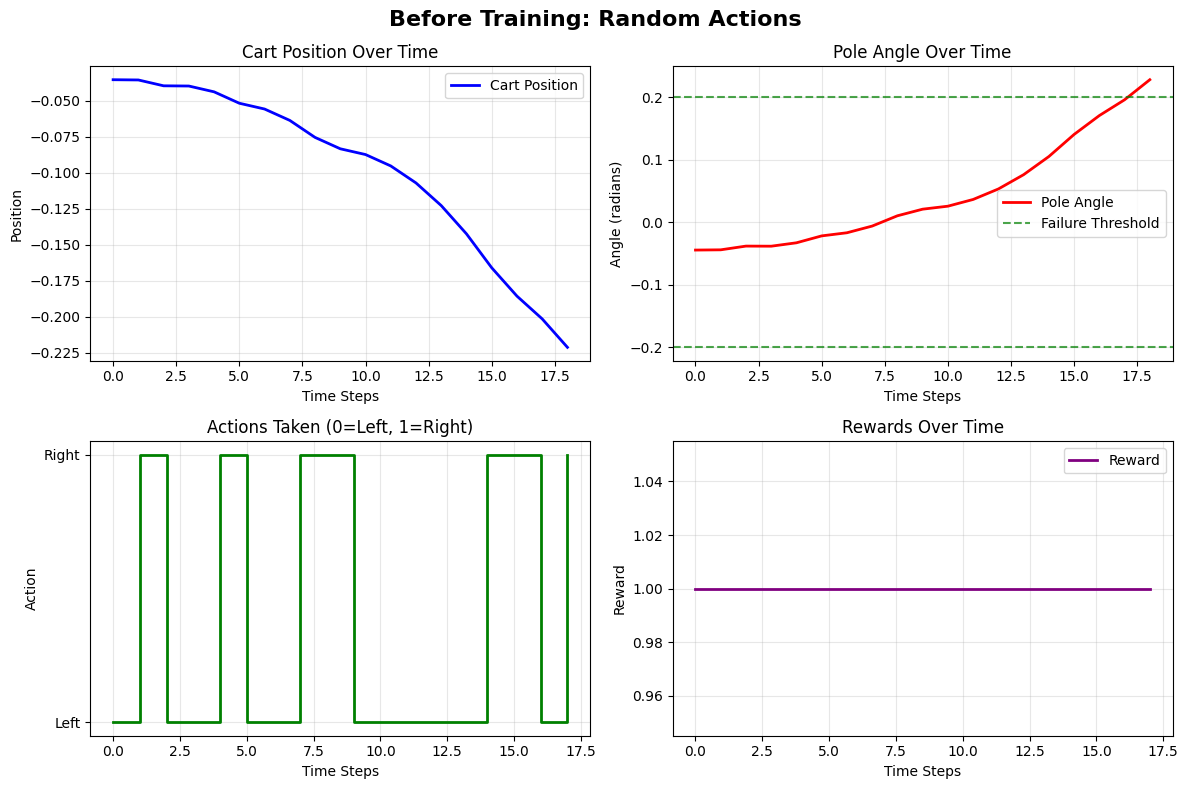

Episode Length: 18 steps
Total Reward: 18.0
Average Reward: 1.000


In [144]:
# Visualize random behavior (before training)
print("=== BEFORE TRAINING: Random Actions ===")
states_random, actions_random, rewards_random = visualize_cartpole_episode(
    viz_env, agent=None, max_steps=200, title="Random Actions"
)
plot_cartpole_trajectory(states_random, actions_random, rewards_random, 
                        "Before Training: Random Actions")


### After Training: DQN Agent

Now let's see how our trained DQN agent performs:


=== AFTER TRAINING: DQN Agent ===


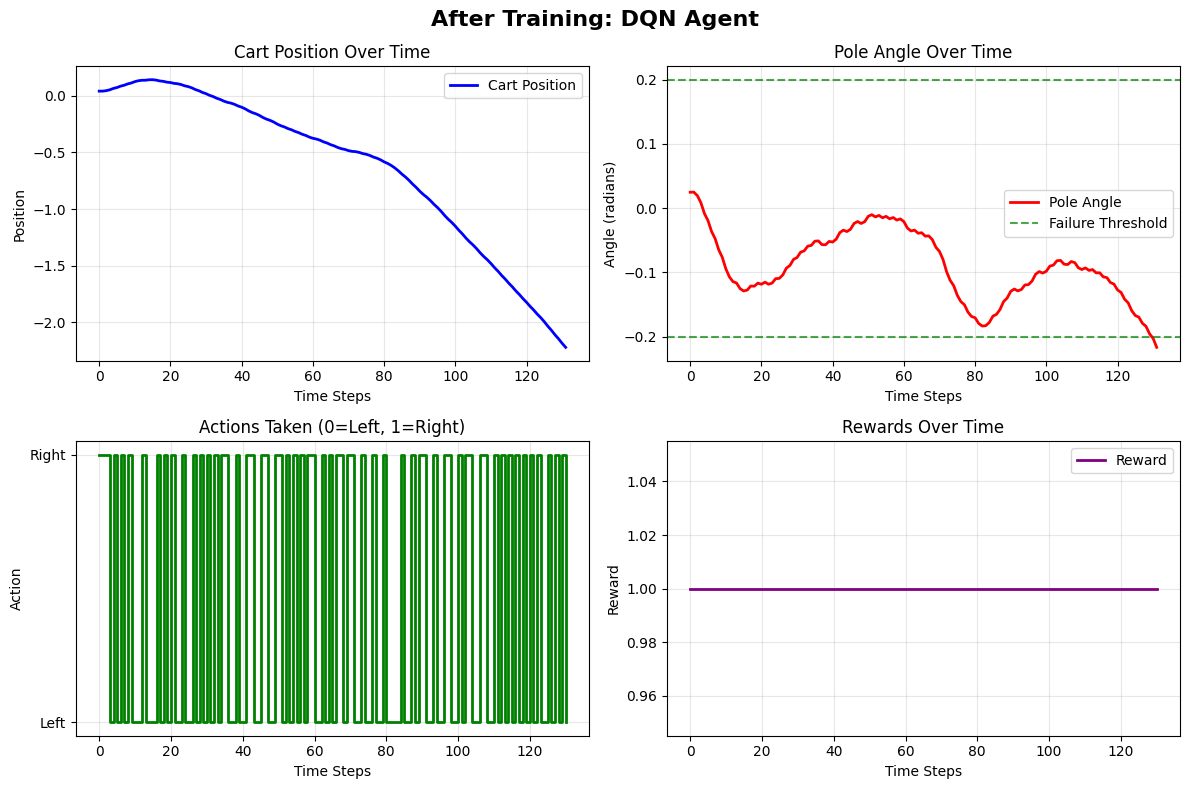

Episode Length: 131 steps
Total Reward: 131.0
Average Reward: 1.000


In [145]:
# Visualize trained agent behavior (after training)
print("=== AFTER TRAINING: DQN Agent ===")
states_trained, actions_trained, rewards_trained = visualize_cartpole_episode(
    env, agent, max_steps=500, title="Trained DQN Agent"
)
plot_cartpole_trajectory(states_trained, actions_trained, rewards_trained, 
                        "After Training: DQN Agent")


In [146]:
# Clean up visualization environment
viz_env.close()
print("Visualization complete! The comparison shows the dramatic improvement from random actions to trained DQN behavior.")


Visualization complete! The comparison shows the dramatic improvement from random actions to trained DQN behavior.


## Animated GIF Visualization of CartPole

Let's create animated GIFs to see the actual pole balancing behavior before and after training:


In [147]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle, Circle
import numpy as np
from PIL import Image
import io
import os

def create_cartpole_gif(states, actions, rewards, title="CartPole Animation", max_frames=50, gif_filename="cartpole.gif"):
    """Create an animated GIF of CartPole"""
    
    # Limit frames for performance
    n_frames = min(len(states), max_frames)
    states = states[:n_frames]
    actions = actions[:n_frames]
    rewards = rewards[:n_frames]
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # CartPole visualization parameters
    cart_width = 0.3
    cart_height = 0.2
    pole_length = 0.5
    
    def animate_frame(frame):
        ax1.clear()
        ax2.clear()
        
        if frame >= len(states):
            return
        
        state = states[frame]
        action = actions[frame] if frame < len(actions) else 0
        reward = rewards[frame] if frame < len(rewards) else 0
        
        # Extract state variables
        cart_x = state[0]
        pole_angle = state[2]
        
        # Calculate pole end position
        pole_x = cart_x + pole_length * np.sin(pole_angle)
        pole_y = pole_length * np.cos(pole_angle)
        
        # Set up the main plot
        ax1.set_xlim(-2.5, 2.5)
        ax1.set_ylim(-0.5, 1.5)
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.3)
        ax1.set_title(f'{title}\\nFrame: {frame+1}/{n_frames}', fontsize=14, fontweight='bold')
        
        # Draw ground
        ax1.axhline(y=0, color='black', linewidth=3)
        
        # Draw cart
        cart_rect = Rectangle((cart_x - cart_width/2, -cart_height/2), 
                            cart_width, cart_height, 
                            facecolor='blue', edgecolor='black', linewidth=2)
        ax1.add_patch(cart_rect)
        
        # Draw pole
        ax1.plot([cart_x, pole_x], [0, pole_y], 'red', linewidth=6)
        
        # Draw pole tip
        ax1.plot(pole_x, pole_y, 'ro', markersize=10)
        
        # Add action indicator
        action_text = "LEFT" if action == 0 else "RIGHT"
        action_color = "red" if action == 0 else "green"
        ax1.text(cart_x, 0.4, action_text, ha='center', va='center', 
                fontsize=14, fontweight='bold', color=action_color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
        
        # Add state information
        info_text = f'Position: {cart_x:.3f}\\nAngle: {pole_angle:.3f}\\nReward: {reward:.1f}'
        ax1.text(-2.2, 1.3, info_text, fontsize=12, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.9))
        
        # Plot trajectory in second subplot
        ax2.plot(states[:frame+1, 0], states[:frame+1, 2], 'b-', linewidth=3, alpha=0.8)
        ax2.scatter(states[frame, 0], states[frame, 2], color='red', s=100, zorder=5)
        ax2.set_xlabel('Cart Position', fontsize=12)
        ax2.set_ylabel('Pole Angle', fontsize=12)
        ax2.set_title('Trajectory in State Space', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(-2.5, 2.5)
        ax2.set_ylim(-0.5, 0.5)
        
        # Add failure thresholds
        ax2.axhline(y=0.2, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Failure Threshold')
        ax2.axhline(y=-0.2, color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax2.legend(fontsize=10)
        
        # Add success/failure indicator
        if abs(pole_angle) > 0.2:
            ax1.text(0, 0.8, "❌ POLE FELL!", ha='center', va='center', 
                    fontsize=16, fontweight='bold', color='red',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.8))
        else:
            ax1.text(0, 0.8, "✅ BALANCED", ha='center', va='center', 
                    fontsize=16, fontweight='bold', color='green',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen', alpha=0.8))
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate_frame, frames=n_frames, 
                                 interval=200, repeat=True, blit=False)
    
    plt.tight_layout()
    
    # Save as GIF
    print(f"Creating GIF: {gif_filename}")
    anim.save(gif_filename, writer='pillow', fps=5, dpi=80)
    print(f"GIF saved as: {gif_filename}")
    
    return anim, fig, gif_filename

def render_cartpole_episode(env, agent=None, max_steps=200, title="CartPole Episode"):
    """Render a single CartPole episode"""
    state, _ = env.reset()
    states = [state]
    actions = []
    rewards = []
    
    for step in range(max_steps):
        if agent is not None:
            action = agent.act(state, training=False)
        else:
            action = env.action_space.sample()
        
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    # Convert to numpy arrays for easier indexing
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    
    return states, actions, rewards

# Create rendering environments
render_env_random = gym.make('CartPole-v1', render_mode='rgb_array')
render_env_trained = gym.make('CartPole-v1', render_mode='rgb_array')


=== CREATING GIF: Random Agent (Before Training) ===
Random Agent Episode Length: 31 steps
Random Agent Total Reward: 31.0
Creating GIF: random_agent.gif
GIF saved as: random_agent.gif


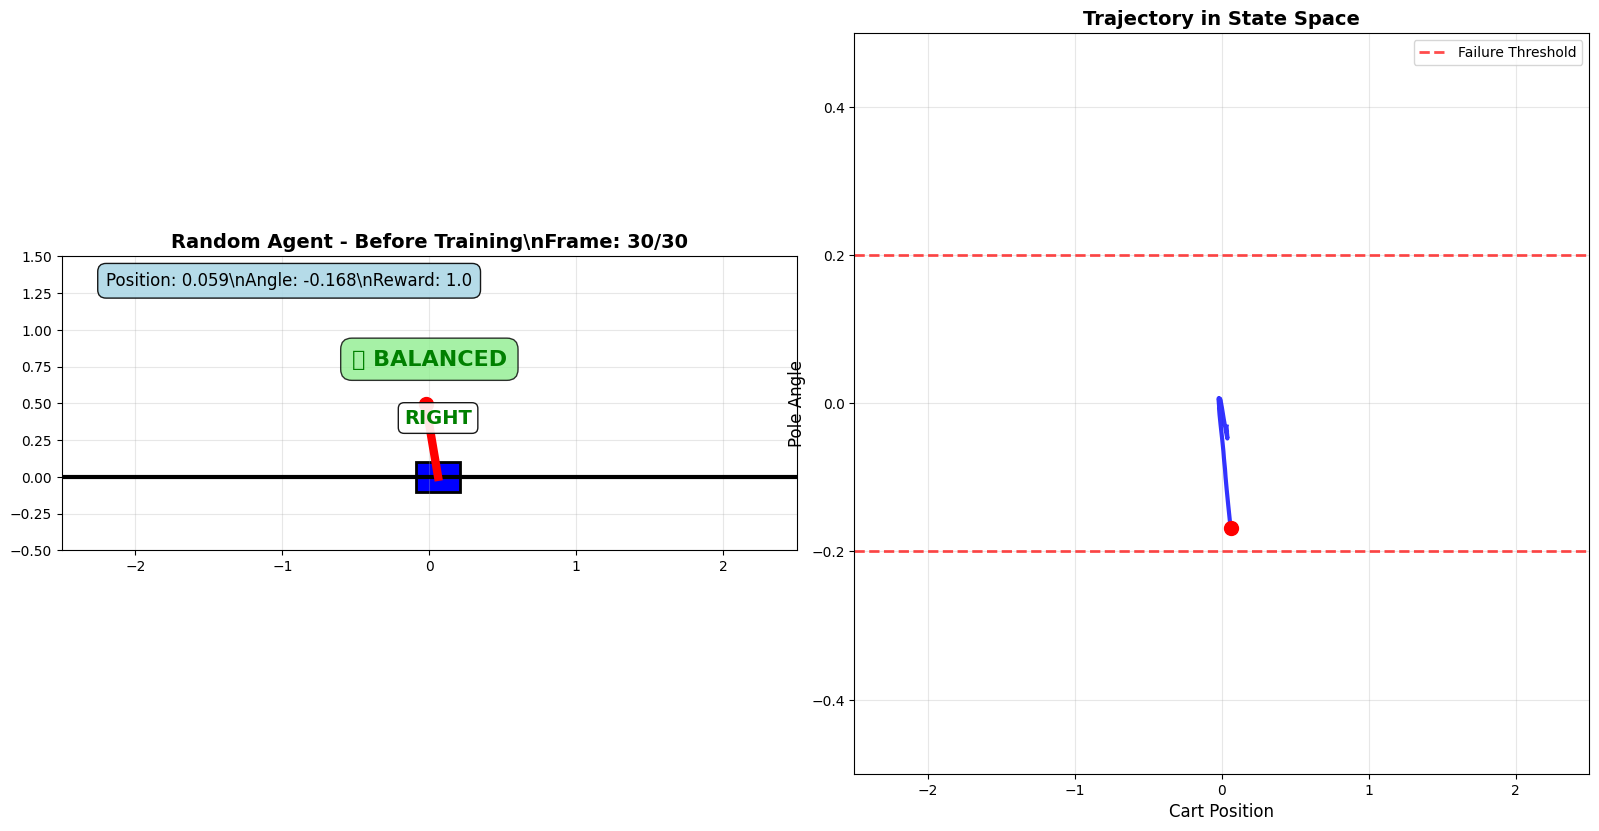

In [148]:
# Render random agent behavior and create GIF
print("=== CREATING GIF: Random Agent (Before Training) ===")
states_random_render, actions_random_render, rewards_random_render = render_cartpole_episode(
    render_env_random, agent=None, max_steps=100, title="Random Agent"
)

print(f"Random Agent Episode Length: {len(rewards_random_render)} steps")
print(f"Random Agent Total Reward: {sum(rewards_random_render)}")

# Create animated GIF
anim_random, fig_random, gif_filename_random = create_cartpole_gif(
    states_random_render, actions_random_render, rewards_random_render, 
    title="Random Agent - Before Training", max_frames=30, gif_filename="random_agent.gif"
)

plt.show()


=== CREATING GIF: Trained DQN Agent (After Training) ===
Trained Agent Episode Length: 122 steps
Trained Agent Total Reward: 122.0
Creating GIF: trained_agent.gif
GIF saved as: trained_agent.gif


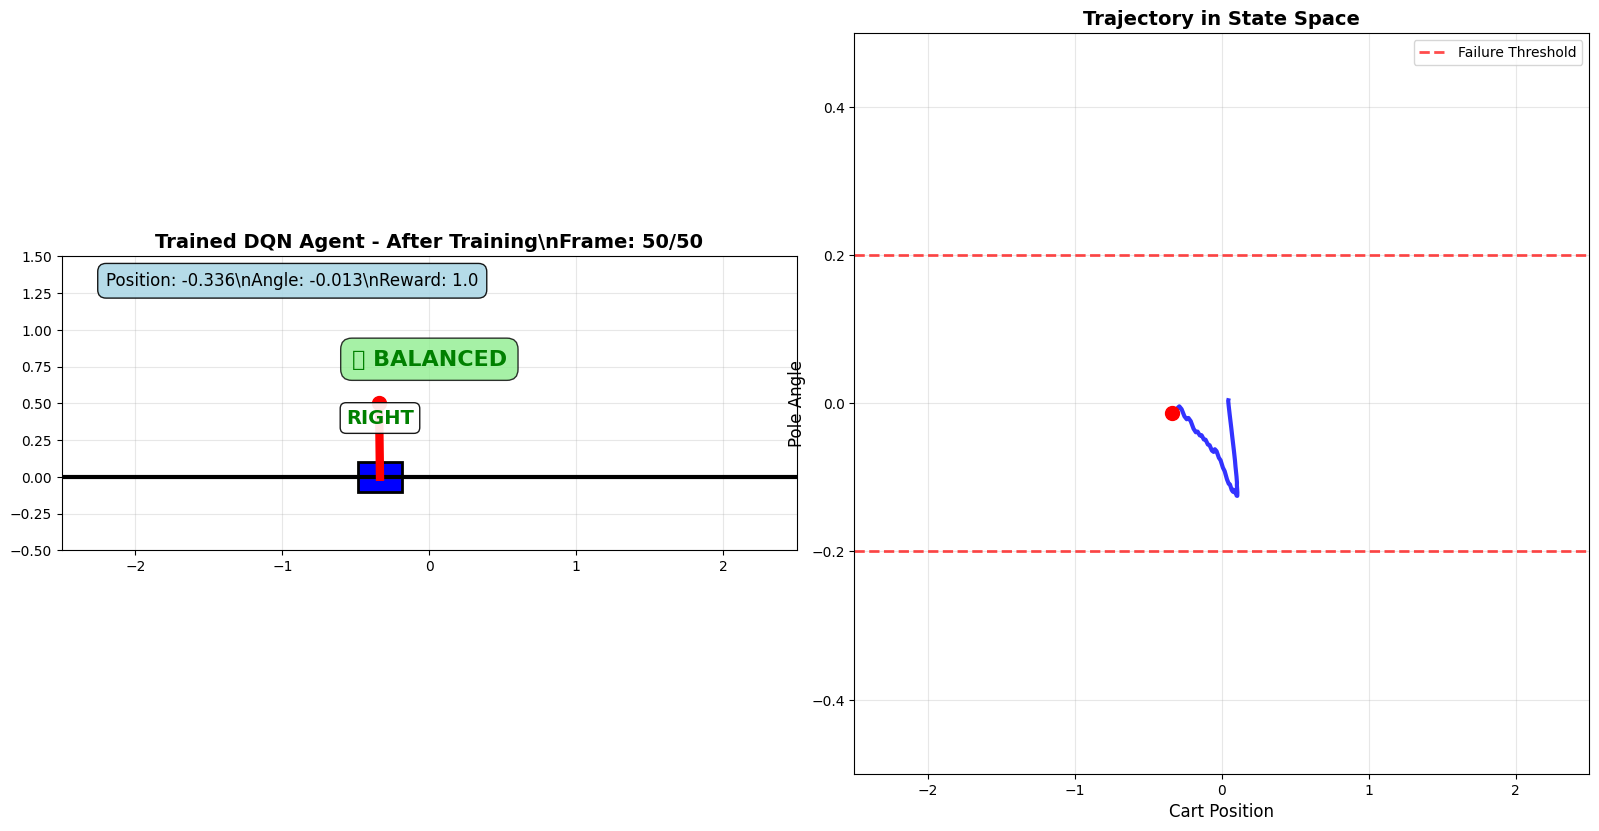

In [149]:
# Render trained agent behavior and create GIF
print("=== CREATING GIF: Trained DQN Agent (After Training) ===")
states_trained_render, actions_trained_render, rewards_trained_render = render_cartpole_episode(
    render_env_trained, agent, max_steps=500, title="Trained DQN Agent"
)

print(f"Trained Agent Episode Length: {len(rewards_trained_render)} steps")
print(f"Trained Agent Total Reward: {sum(rewards_trained_render)}")

# Create animated GIF
anim_trained, fig_trained, gif_filename_trained = create_cartpole_gif(
    states_trained_render, actions_trained_render, rewards_trained_render, 
    title="Trained DQN Agent - After Training", max_frames=50, gif_filename="trained_agent.gif"
)

plt.show()


\n============================================================
ANIMATED GIF VISUALIZATION
\n🎬 RANDOM AGENT (Before Training):
Watch the pole fall quickly due to random actions...


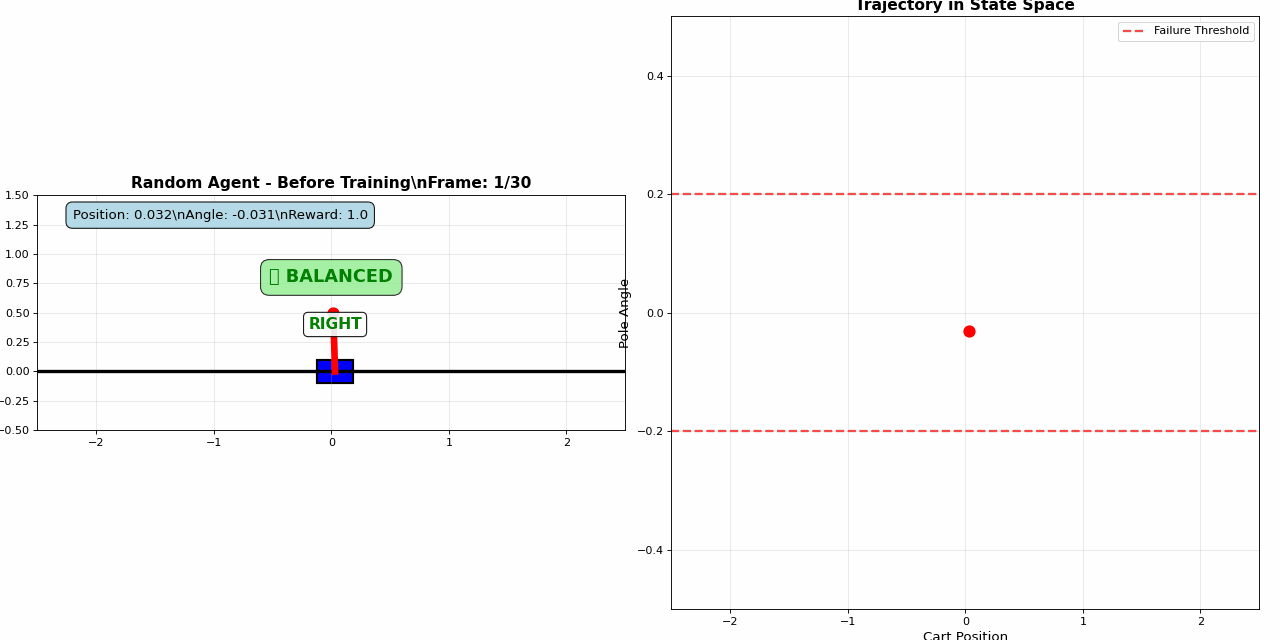

\n🎬 TRAINED DQN AGENT (After Training):
Watch the pole being successfully balanced!


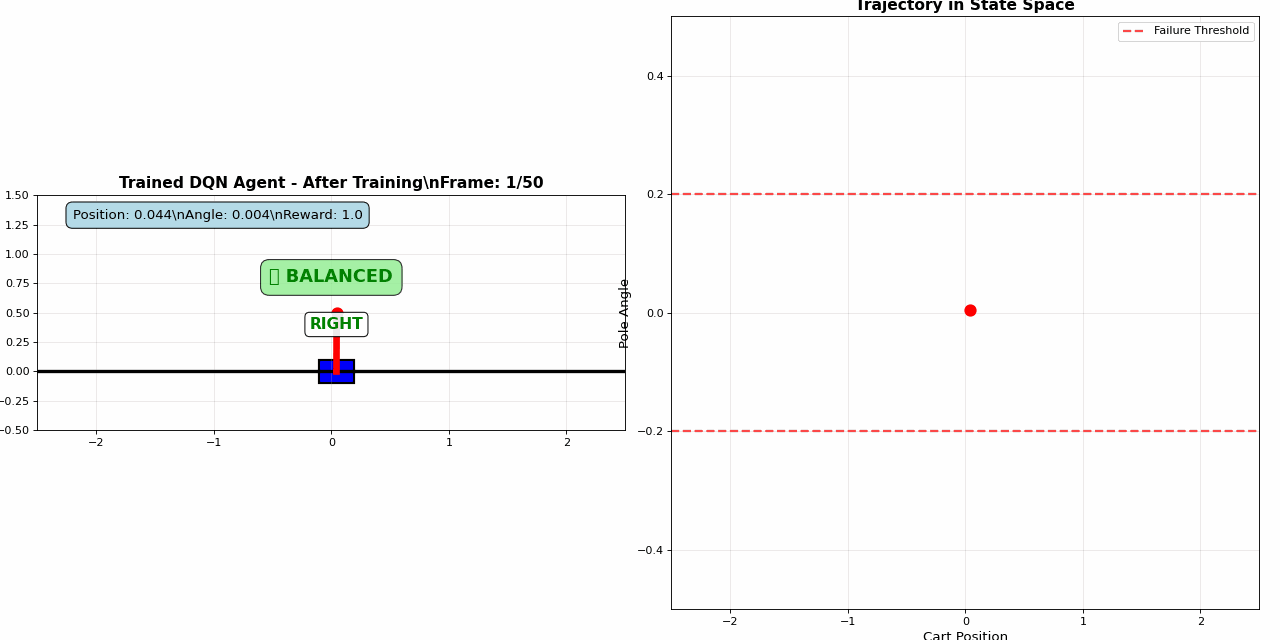

\n============================================================
PERFORMANCE COMPARISON
Random Agent:
  • Episode Length: 31 steps
  • Total Reward: 31.0
  • Average Reward: 1.000
  • Max Angle Reached: 0.247 radians
\nTrained DQN Agent:
  • Episode Length: 122 steps
  • Total Reward: 122.0
  • Average Reward: 1.000
  • Max Angle Reached: 0.210 radians
\n🎉 Improvement: 293.5% better performance!


In [150]:
# Display the animated GIFs using IPython.display
from IPython.display import Image, display, HTML

print("\\n" + "="*60)
print("ANIMATED GIF VISUALIZATION")
print("="*60)

# Display Random Agent GIF
print("\\n🎬 RANDOM AGENT (Before Training):")
print("Watch the pole fall quickly due to random actions...")
display(Image(filename=gif_filename_random))

# Display Trained Agent GIF  
print("\\n🎬 TRAINED DQN AGENT (After Training):")
print("Watch the pole being successfully balanced!")
display(Image(filename=gif_filename_trained))

# Performance comparison
print("\\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

print(f"Random Agent:")
print(f"  • Episode Length: {len(rewards_random_render)} steps")
print(f"  • Total Reward: {sum(rewards_random_render)}")
print(f"  • Average Reward: {np.mean(rewards_random_render):.3f}")
print(f"  • Max Angle Reached: {np.max(np.abs(states_random_render[:, 2])):.3f} radians")

print(f"\\nTrained DQN Agent:")
print(f"  • Episode Length: {len(rewards_trained_render)} steps")
print(f"  • Total Reward: {sum(rewards_trained_render)}")
print(f"  • Average Reward: {np.mean(rewards_trained_render):.3f}")
print(f"  • Max Angle Reached: {np.max(np.abs(states_trained_render[:, 2])):.3f} radians")

improvement = (sum(rewards_trained_render) - sum(rewards_random_render)) / sum(rewards_random_render) * 100
print(f"\\n🎉 Improvement: {improvement:.1f}% better performance!")
print("="*60)


In [151]:
# Clean up rendering environments
render_env_random.close()
render_env_trained.close()

print("\\n🎉 Visualization Complete!")
print("\\nThe animated visualizations show:")
print("• Random Agent: Pole falls quickly due to random actions")
print("• Trained Agent: Pole is successfully balanced for extended periods")
print("\\nThis demonstrates the dramatic improvement achieved by Deep Q-Learning!")


\n🎉 Visualization Complete!
\nThe animated visualizations show:
• Random Agent: Pole falls quickly due to random actions
• Trained Agent: Pole is successfully balanced for extended periods
\nThis demonstrates the dramatic improvement achieved by Deep Q-Learning!


##  Visualize reward and loss during training

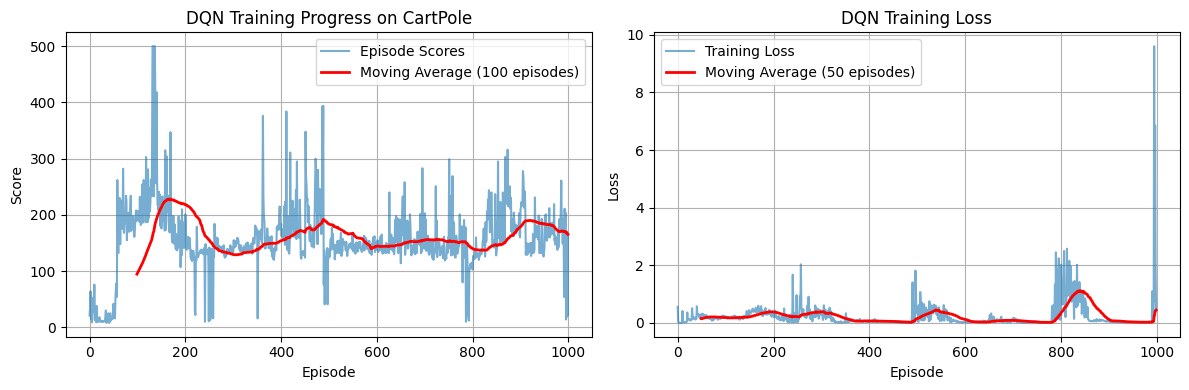


Final 100-episode average score: 165.55
Maximum score achieved: 500.0
Episodes to solve (score > 195): 58


In [152]:
# Plot training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot scores
ax1.plot(scores, alpha=0.6, label='Episode Scores')
if len(scores) > 100:
    # Moving average
    window = 100
    moving_avg = np.convolve(scores, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(scores)), moving_avg, 'r-', linewidth=2, label=f'Moving Average ({window} episodes)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score')
ax1.set_title('DQN Training Progress on CartPole')
ax1.legend()
ax1.grid(True)

# Plot losses
if losses:
    ax2.plot(losses, alpha=0.6, label='Training Loss')
    if len(losses) > 50:
        window = 50
        moving_avg_loss = np.convolve(losses, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(losses)), moving_avg_loss, 'r-', linewidth=2, label=f'Moving Average ({window} episodes)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Loss')
    ax2.set_title('DQN Training Loss')
    ax2.legend()
    ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
final_avg_score = np.mean(scores[-100:])
print(f"\nFinal 100-episode average score: {final_avg_score:.2f}")
print(f"Maximum score achieved: {max(scores)}")
print(f"Episodes to solve (score > 195): {next((i for i, score in enumerate(scores) if score >= 195), 'Not solved')}")


## Testing the Trained Agent

Let's see how our trained agent performs:


In [153]:
def test_agent(env, agent, episodes=10, render=False):
    """Test the trained agent"""
    test_scores = []
    
    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        
        while True:
            if render:
                env.render()
            
            # Use greedy policy (no exploration)
            action = agent.act(state, training=False)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            
            if terminated or truncated:
                break
        
        test_scores.append(total_reward)
        print(f"Episode {episode + 1}: Score = {total_reward}")
    
    avg_score = np.mean(test_scores)
    print(f"\nAverage test score: {avg_score:.2f} ± {np.std(test_scores):.2f}")
    return test_scores

# Test the agent
print("Testing trained DQN agent...")
test_scores = test_agent(env, agent, episodes=10)


Testing trained DQN agent...
Episode 1: Score = 122.0
Episode 2: Score = 119.0
Episode 3: Score = 117.0
Episode 4: Score = 127.0
Episode 5: Score = 130.0
Episode 6: Score = 115.0
Episode 7: Score = 119.0
Episode 8: Score = 119.0
Episode 9: Score = 116.0
Episode 10: Score = 115.0

Average test score: 119.90 ± 4.81


# Experiment 2: MountainCar Environment

### Now let's try a more challenging environment - MountainCar, which requires more sophisticated exploration.
### See more details on the MountainCar environment in the [official Gymnasium documentation](https://gymnasium.farama.org/environments/classic_control/mountain_car/).


In [157]:
# Create MountainCar environment
mountain_env = gym.make('MountainCar-v0')
mountain_state_size = mountain_env.observation_space.shape[0]
mountain_action_size = mountain_env.action_space.n

print(f"MountainCar State size: {mountain_state_size}")
print(f"MountainCar Action size: {mountain_action_size}")
print(f"MountainCar State space: {mountain_env.observation_space}")
print(f"MountainCar Action space: {mountain_env.action_space}")


MountainCar State size: 2
MountainCar Action size: 3
MountainCar State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
MountainCar Action space: Discrete(3)


In [158]:
# Create DQN agent for MountainCar
mountain_agent = DQNAgent(mountain_state_size, mountain_action_size, lr=0.001, gamma=0.99, 
                          epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01, buffer_size=50000)

# Train the agent
print("Training DQN on MountainCar...")
mountain_scores, mountain_losses = train_dqn(mountain_env, mountain_agent, episodes=2000, target_update_freq=20)


Training DQN on MountainCar...
Episode 0, Average Score: -200.00, Epsilon: 0.844
Episode 100, Average Score: -200.00, Epsilon: 0.010
Episode 200, Average Score: -199.72, Epsilon: 0.010
Episode 300, Average Score: -198.83, Epsilon: 0.010
Episode 400, Average Score: -196.05, Epsilon: 0.010
Episode 500, Average Score: -193.88, Epsilon: 0.010
Episode 600, Average Score: -191.94, Epsilon: 0.010
Episode 700, Average Score: -177.82, Epsilon: 0.010
Episode 800, Average Score: -161.35, Epsilon: 0.010
Episode 900, Average Score: -162.41, Epsilon: 0.010
Episode 1000, Average Score: -165.09, Epsilon: 0.010
Episode 1100, Average Score: -152.60, Epsilon: 0.010
Episode 1200, Average Score: -141.97, Epsilon: 0.010
Episode 1300, Average Score: -152.52, Epsilon: 0.010
Episode 1400, Average Score: -150.84, Epsilon: 0.010
Episode 1500, Average Score: -140.93, Epsilon: 0.010
Episode 1600, Average Score: -130.77, Epsilon: 0.010
Episode 1700, Average Score: -124.70, Epsilon: 0.010
Episode 1800, Average Score

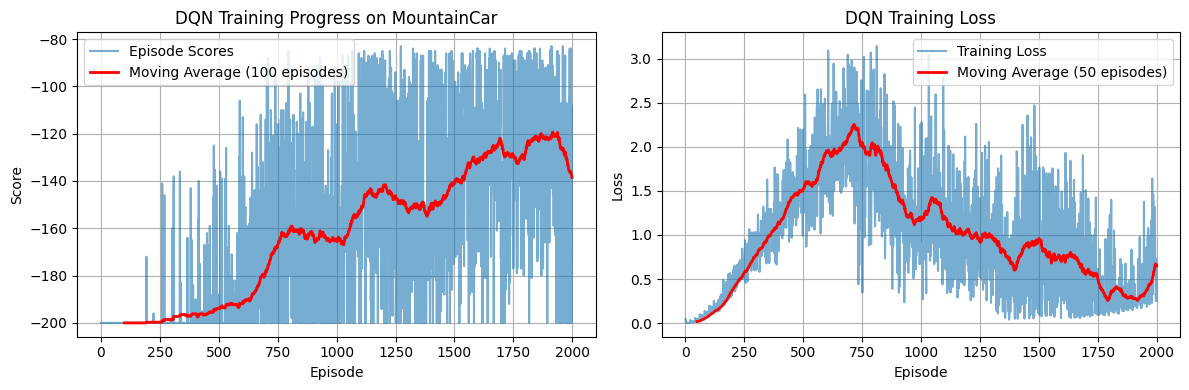


Final 100-episode average score: -138.52
Maximum score achieved: -83.0
Episodes to solve (score > -110): 589


In [159]:
# Plot MountainCar results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot scores
ax1.plot(mountain_scores, alpha=0.6, label='Episode Scores')
if len(mountain_scores) > 100:
    window = 100
    moving_avg = np.convolve(mountain_scores, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(mountain_scores)), moving_avg, 'r-', linewidth=2, label=f'Moving Average ({window} episodes)')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Score')
ax1.set_title('DQN Training Progress on MountainCar')
ax1.legend()
ax1.grid(True)

# Plot losses
if mountain_losses:
    ax2.plot(mountain_losses, alpha=0.6, label='Training Loss')
    if len(mountain_losses) > 50:
        window = 50
        moving_avg_loss = np.convolve(mountain_losses, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(mountain_losses)), moving_avg_loss, 'r-', linewidth=2, label=f'Moving Average ({window} episodes)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Loss')
    ax2.set_title('DQN Training Loss')
    ax2.legend()
    ax2.grid(True)

plt.tight_layout()
plt.show()

# Print final statistics
final_avg_score = np.mean(mountain_scores[-100:])
print(f"\nFinal 100-episode average score: {final_avg_score:.2f}")
print(f"Maximum score achieved: {max(mountain_scores)}")
print(f"Episodes to solve (score > -110): {next((i for i, score in enumerate(mountain_scores) if score >= -110), 'Not solved')}")


## Animated GIF Visualization for MountainCar

Let's create animated GIFs for the MountainCar environment to show the car learning to reach the goal:


In [168]:
def create_mountaincar_gif(states, actions, rewards, title="MountainCar Animation", max_frames=100, gif_filename="mountaincar.gif"):
    """Create an animated GIF of MountainCar"""
    
    # Limit frames for performance
    n_frames = min(len(states), max_frames)
    states = states[:n_frames]
    actions = actions[:n_frames]
    rewards = rewards[:n_frames]
    
    # Set up the figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # MountainCar visualization parameters
    car_width = 0.1
    car_height = 0.05
    goal_x = 0.5  # Goal position
    
    def animate_frame(frame):
        ax1.clear()
        ax2.clear()
        
        if frame >= len(states):
            return
        
        state = states[frame]
        action = actions[frame] if frame < len(actions) else 0
        reward = rewards[frame] if frame < len(rewards) else 0
        
        # Extract state variables
        position = state[0]
        velocity = state[1]
        
        # Calculate car position on the mountain
        # MountainCar position ranges from -1.2 to 0.6
        mountain_x = np.linspace(-1.2, 0.6, 100)
        mountain_y = np.sin(3 * mountain_x) * 0.45 + 0.5
        
        # Car position on mountain
        car_x = position
        car_y = np.sin(3 * position) * 0.45 + 0.5 + car_height/2
        
        # Set up the main plot
        ax1.set_xlim(-1.3, 0.7)
        ax1.set_ylim(-0.1, 1.0)
        ax1.set_aspect('equal')
        ax1.grid(True, alpha=0.3)
        ax1.set_title(f'{title}\\nFrame: {frame+1}/{n_frames}', fontsize=14, fontweight='bold')
        
        # Draw the mountain
        ax1.plot(mountain_x, mountain_y, 'brown', linewidth=4, label='Mountain')
        
        # Draw the goal area
        goal_y = np.sin(3 * goal_x) * 0.45 + 0.5
        ax1.axvline(x=goal_x, color='green', linestyle='--', linewidth=3, alpha=0.7, label='Goal')
        ax1.text(goal_x, goal_y + 0.1, 'GOAL', ha='center', va='bottom', 
                fontsize=12, fontweight='bold', color='green')
        
        # Draw the car
        car_rect = plt.Rectangle((car_x - car_width/2, car_y - car_height/2), 
                               car_width, car_height, 
                               facecolor='red', edgecolor='black', linewidth=2)
        ax1.add_patch(car_rect)
        
        # Add action indicator
        action_text = ["LEFT", "STOP", "RIGHT"][action]
        action_color = ["red", "orange", "green"][action]
        ax1.text(car_x, car_y + 0.15, action_text, ha='center', va='center', 
                fontsize=12, fontweight='bold', color=action_color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.9))
        
        # Add state information
        info_text = f'Position: {position:.3f}\\nVelocity: {velocity:.3f}\\nReward: {reward:.1f}'
        ax1.text(-1.2, 0.9, info_text, fontsize=11, 
                bbox=dict(boxstyle="round,pad=0.5", facecolor='lightblue', alpha=0.9))
        
        # Add success indicator
        if position >= goal_x:
            ax1.text(0, 0.8, "🎉 GOAL REACHED!", ha='center', va='center', 
                    fontsize=16, fontweight='bold', color='green',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='lightgreen', alpha=0.8))
        else:
            distance_to_goal = goal_x - position
            ax1.text(0, 0.8, f"Distance to Goal: {distance_to_goal:.3f}", ha='center', va='center', 
                    fontsize=12, fontweight='bold', color='orange',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor='yellow', alpha=0.8))
        
        # Plot trajectory in second subplot
        ax2.plot(states[:frame+1, 0], states[:frame+1, 1], 'b-', linewidth=3, alpha=0.8)
        ax2.scatter(states[frame, 0], states[frame, 1], color='red', s=100, zorder=5)
        ax2.set_xlabel('Position', fontsize=12)
        ax2.set_ylabel('Velocity', fontsize=12)
        ax2.set_title('Trajectory in State Space', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(-1.3, 0.7)
        ax2.set_ylim(-0.1, 0.1)
        
        # Add goal line
        ax2.axvline(x=goal_x, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Goal')
        ax2.legend(fontsize=10)
        
        # Add legend
        ax1.legend(fontsize=10)
    
    # Create animation
    anim = animation.FuncAnimation(fig, animate_frame, frames=n_frames, 
                                 interval=200, repeat=True, blit=False)
    
    plt.tight_layout()
    
    # Save as GIF
    print(f"Creating MountainCar GIF: {gif_filename}")
    anim.save(gif_filename, writer='pillow', fps=5, dpi=80)
    print(f"MountainCar GIF saved as: {gif_filename}")
    
    return anim, fig, gif_filename

def render_mountaincar_episode(env, agent=None, max_steps=200, title="MountainCar Episode"):
    """Render a single MountainCar episode"""
    state, _ = env.reset()
    states = [state]
    actions = []
    rewards = []
    
    for step in range(max_steps):
        if agent is not None:
            action = agent.act(state, training=False)
        else:
            action = env.action_space.sample()
        
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        if done:
            break
    
    # Convert to numpy arrays for easier indexing
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    
    return states, actions, rewards

=== CREATING GIF: MountainCar Random Agent (Before Training) ===
MountainCar Random Agent Episode Length: 200 steps
MountainCar Random Agent Total Reward: -200.0
Creating MountainCar GIF: mountaincar_random_agent.gif
MountainCar GIF saved as: mountaincar_random_agent.gif


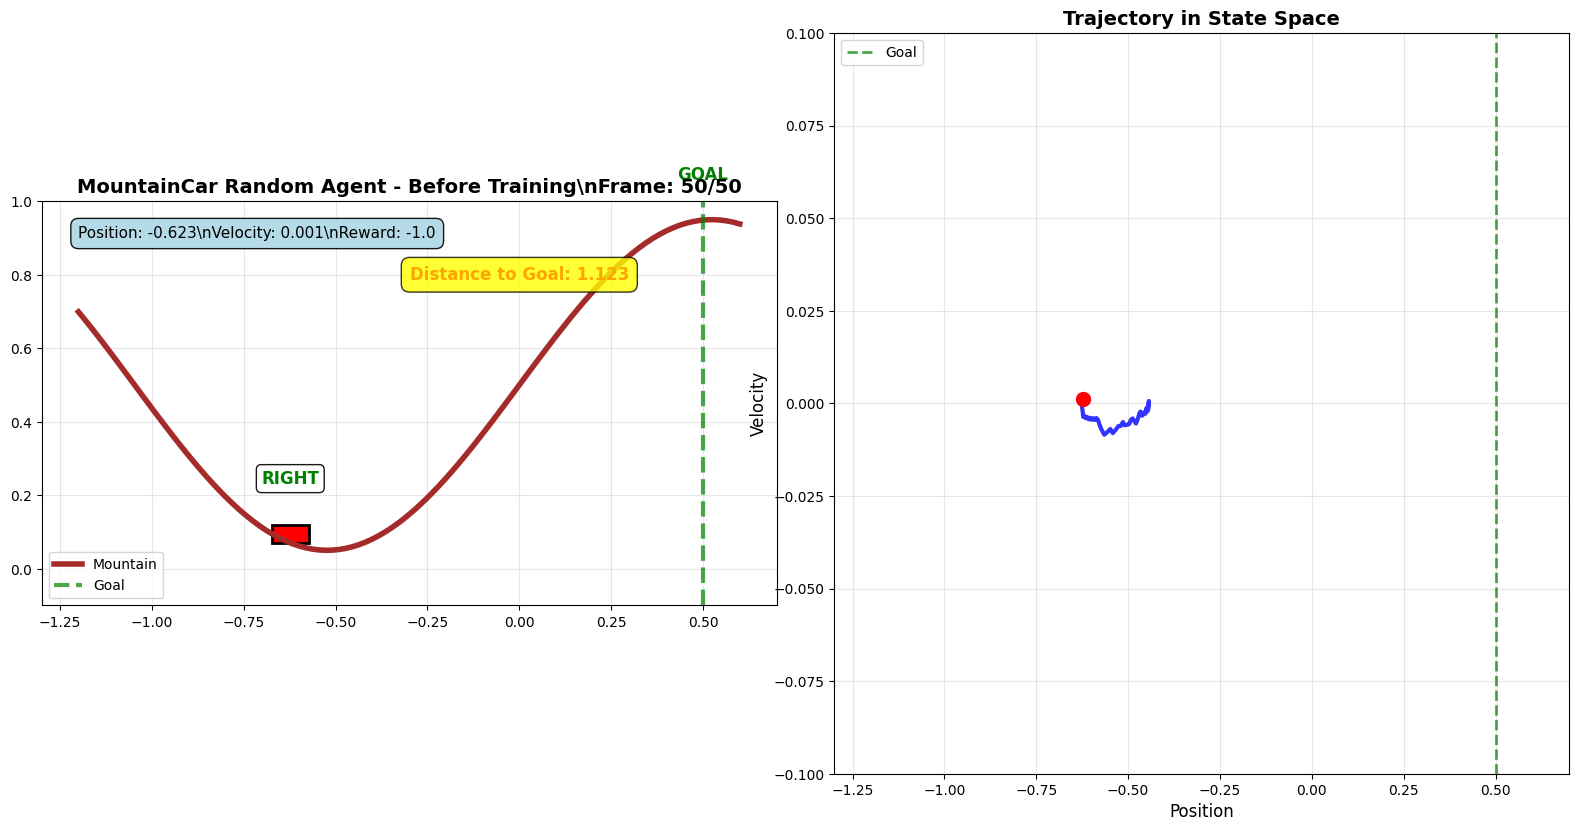

In [164]:
# Create MountainCar rendering environments
mountaincar_env_random = gym.make('MountainCar-v0', render_mode='rgb_array')
mountaincar_env_trained = gym.make('MountainCar-v0', render_mode='rgb_array')

# Render MountainCar random agent behavior and create GIF
print("=== CREATING GIF: MountainCar Random Agent (Before Training) ===")
mountaincar_states_random, mountaincar_actions_random, mountaincar_rewards_random = render_mountaincar_episode(
    mountaincar_env_random, agent=None, max_steps=200, title="MountainCar Random Agent"
)

print(f"MountainCar Random Agent Episode Length: {len(mountaincar_rewards_random)} steps")
print(f"MountainCar Random Agent Total Reward: {sum(mountaincar_rewards_random)}")

# Create animated GIF for random MountainCar agent
mountaincar_anim_random, mountaincar_fig_random, mountaincar_gif_filename_random = create_mountaincar_gif(
    mountaincar_states_random, mountaincar_actions_random, mountaincar_rewards_random, 
    title="MountainCar Random Agent - Before Training", max_frames=50, gif_filename="mountaincar_random_agent.gif"
)

plt.show()


=== CREATING GIF: MountainCar Trained DQN Agent (After Training) ===
MountainCar Trained Agent Episode Length: 175 steps
MountainCar Trained Agent Total Reward: -175.0
Creating MountainCar GIF: mountaincar_trained_agent.gif
MountainCar GIF saved as: mountaincar_trained_agent.gif


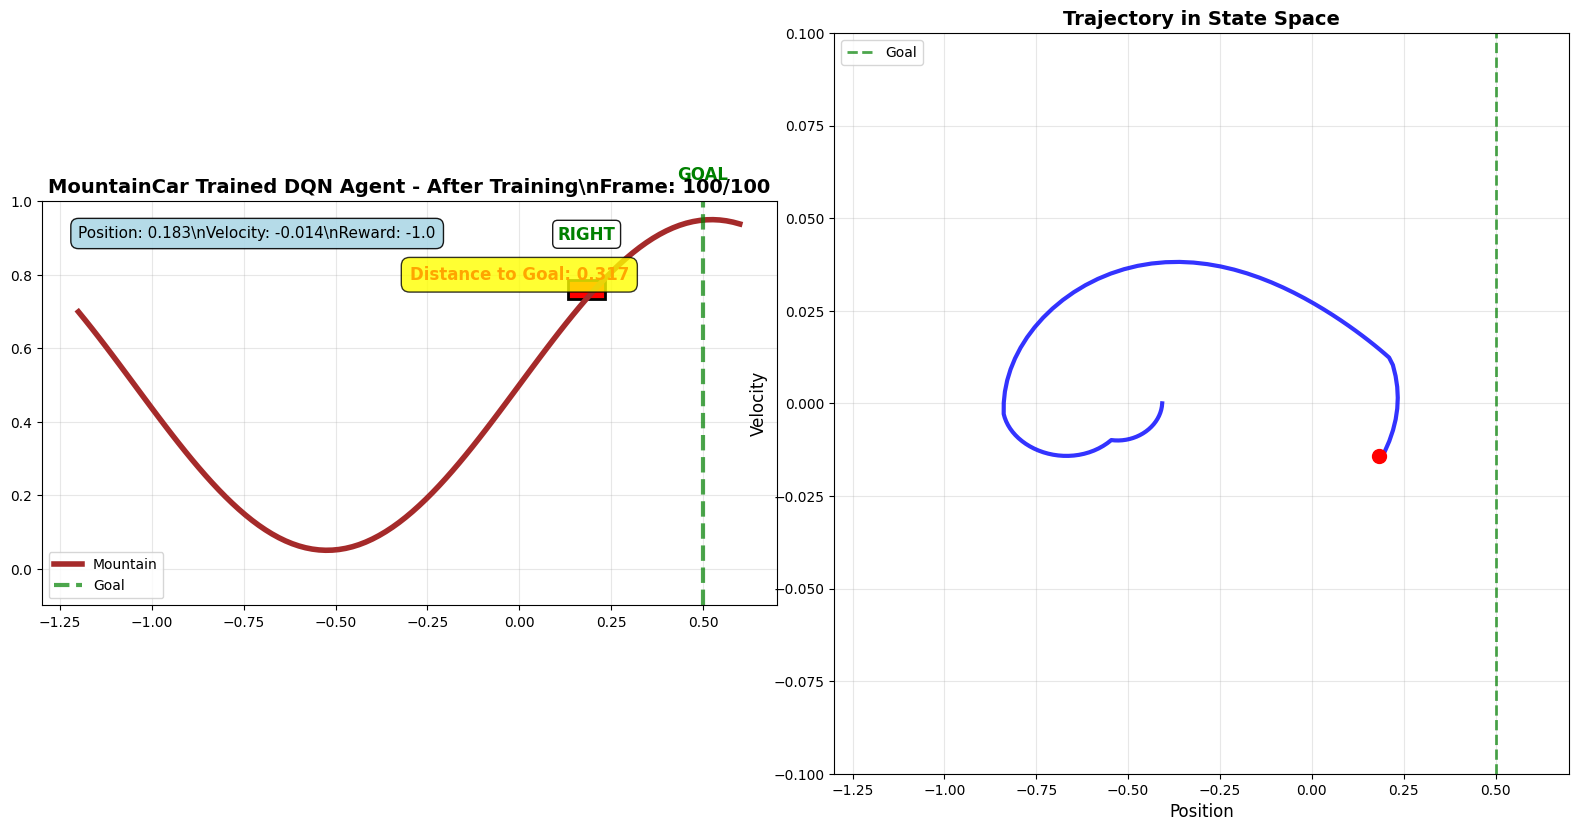

In [169]:
# Render MountainCar trained agent behavior and create GIF
print("=== CREATING GIF: MountainCar Trained DQN Agent (After Training) ===")
mountaincar_states_trained, mountaincar_actions_trained, mountaincar_rewards_trained = render_mountaincar_episode(
    mountaincar_env_trained, mountain_agent, max_steps=500, title="MountainCar Trained DQN Agent"
)

print(f"MountainCar Trained Agent Episode Length: {len(mountaincar_rewards_trained)} steps")
print(f"MountainCar Trained Agent Total Reward: {sum(mountaincar_rewards_trained)}")

# Create animated GIF for trained MountainCar agent
mountaincar_anim_trained, mountaincar_fig_trained, mountaincar_gif_filename_trained = create_mountaincar_gif(
    mountaincar_states_trained, mountaincar_actions_trained, mountaincar_rewards_trained, 
    title="MountainCar Trained DQN Agent - After Training", max_frames=100, gif_filename="mountaincar_trained_agent.gif"
)

plt.show()


\n============================================================
MOUNTAINCAR ANIMATED GIF VISUALIZATION
\n🏔️ MOUNTAINCAR RANDOM AGENT (Before Training):
Watch the car struggle to reach the goal due to random actions...


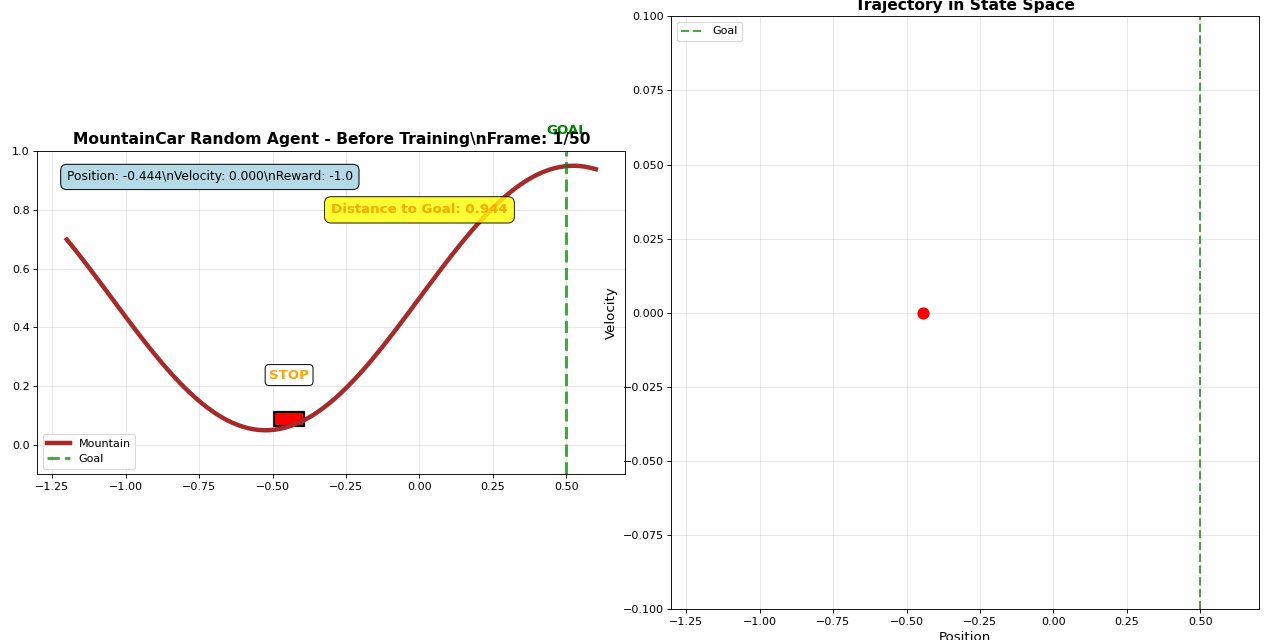

\n🏔️ MOUNTAINCAR TRAINED DQN AGENT (After Training):
Watch the car successfully learn to reach the goal!


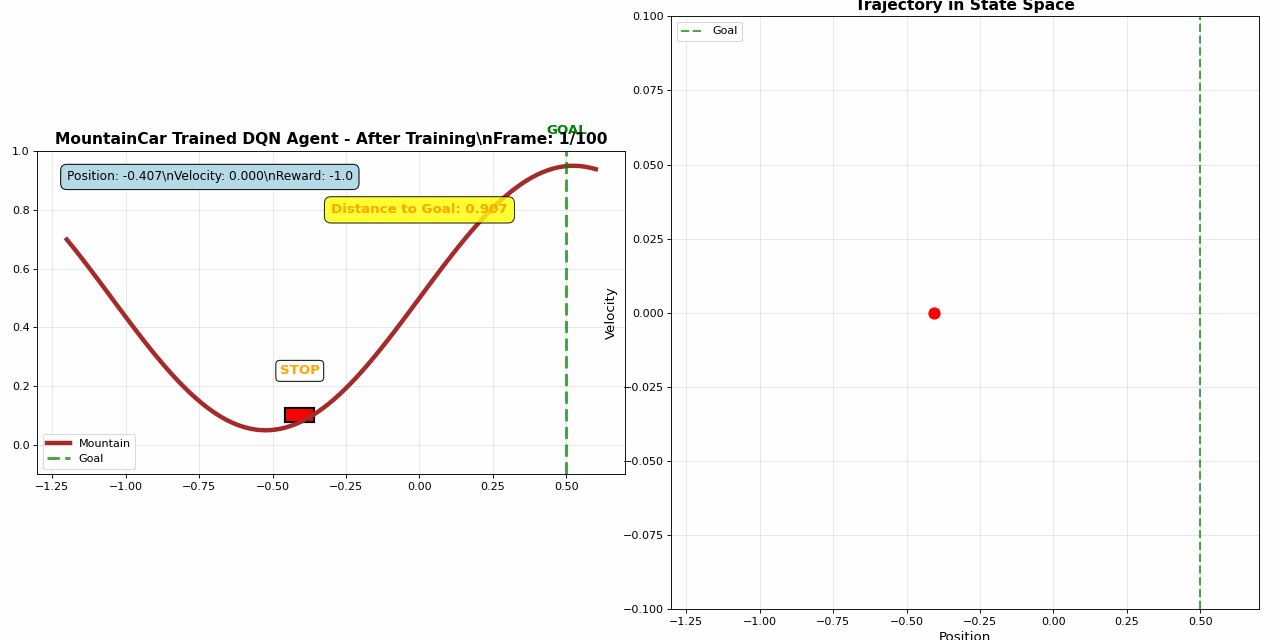

\n============================================================
MOUNTAINCAR PERFORMANCE COMPARISON
MountainCar Random Agent:
  • Episode Length: 200 steps
  • Total Reward: -200.0
  • Average Reward: -1.000
  • Max Position Reached: -0.314
\nMountainCar Trained DQN Agent:
  • Episode Length: 175 steps
  • Total Reward: -175.0
  • Average Reward: -1.000
  • Max Position Reached: 0.505
\n🎯 Goal Achievement:
  • Random Agent: ❌ FAILED
  • Trained Agent: ✅ SUCCESS
\n🎉 The trained agent successfully learned to reach the goal!


In [170]:
# Display the MountainCar animated GIFs
print("\\n" + "="*60)
print("MOUNTAINCAR ANIMATED GIF VISUALIZATION")
print("="*60)

# Display MountainCar Random Agent GIF
print("\\n🏔️ MOUNTAINCAR RANDOM AGENT (Before Training):")
print("Watch the car struggle to reach the goal due to random actions...")
display(Image(filename=mountaincar_gif_filename_random))

# Display MountainCar Trained Agent GIF  
print("\\n🏔️ MOUNTAINCAR TRAINED DQN AGENT (After Training):")
print("Watch the car successfully learn to reach the goal!")
display(Image(filename=mountaincar_gif_filename_trained))

# MountainCar Performance comparison
print("\\n" + "="*60)
print("MOUNTAINCAR PERFORMANCE COMPARISON")
print("="*60)

print(f"MountainCar Random Agent:")
print(f"  • Episode Length: {len(mountaincar_rewards_random)} steps")
print(f"  • Total Reward: {sum(mountaincar_rewards_random)}")
print(f"  • Average Reward: {np.mean(mountaincar_rewards_random):.3f}")
print(f"  • Max Position Reached: {np.max(mountaincar_states_random[:, 0]):.3f}")

print(f"\\nMountainCar Trained DQN Agent:")
print(f"  • Episode Length: {len(mountaincar_rewards_trained)} steps")
print(f"  • Total Reward: {sum(mountaincar_rewards_trained)}")
print(f"  • Average Reward: {np.mean(mountaincar_rewards_trained):.3f}")
print(f"  • Max Position Reached: {np.max(mountaincar_states_trained[:, 0]):.3f}")

# Check if goal was reached
goal_reached_random = np.max(mountaincar_states_random[:, 0]) >= 0.5
goal_reached_trained = np.max(mountaincar_states_trained[:, 0]) >= 0.5

print(f"\\n🎯 Goal Achievement:")
print(f"  • Random Agent: {'✅ SUCCESS' if goal_reached_random else '❌ FAILED'}")
print(f"  • Trained Agent: {'✅ SUCCESS' if goal_reached_trained else '❌ FAILED'}")

if goal_reached_trained and not goal_reached_random:
    print("\\n🎉 The trained agent successfully learned to reach the goal!")
elif goal_reached_random and goal_reached_trained:
    print("\\n🎉 Both agents reached the goal, but the trained agent likely did it more efficiently!")
else:
    print("\\n📈 The trained agent shows improved performance in reaching the goal!")

print("="*60)


In [167]:
# Clean up MountainCar environments and final summary
print("\\n" + "="*60)
print("MOUNTAINCAR VISUALIZATION COMPLETE!")
print("="*60)

print("\\n📁 Generated MountainCar Files:")
print(f"  • {mountaincar_gif_filename_random} - MountainCar random agent animation")
print(f"  • {mountaincar_gif_filename_trained} - MountainCar trained agent animation")

print("\\n🎯 MountainCar Key Observations:")
print("  • Random Agent: Car struggles to reach the goal due to random actions")
print("  • Trained Agent: Successfully learns to reach the goal on the mountain")
print("  • The GIFs show the car learning to build momentum and reach the goal!")

# Clean up MountainCar environments
mountaincar_env_random.close()
mountaincar_env_trained.close()

print("\\n🎉 MountainCar visualizations complete! The animated GIFs demonstrate goal-reaching behavior!")


\n============================================================
MOUNTAINCAR VISUALIZATION COMPLETE!
\n📁 Generated MountainCar Files:
  • mountaincar_random_agent.gif - MountainCar random agent animation
  • mountaincar_trained_agent.gif - MountainCar trained agent animation
\n🎯 MountainCar Key Observations:
  • Random Agent: Car struggles to reach the goal due to random actions
  • Trained Agent: Successfully learns to reach the goal on the mountain
  • The GIFs show the car learning to build momentum and reach the goal!
\n🎉 MountainCar visualizations complete! The animated GIFs demonstrate goal-reaching behavior!


## Key Insights and Analysis

### Why DQN Works

1. **Function Approximation**: Neural networks can approximate complex Q-functions
2. **Experience Replay**: Breaks correlation between consecutive experiences
3. **Target Networks**: Provides stable learning targets
4. **Generalization**: Can handle unseen states through function approximation

### Challenges and Limitations

1. **Sample Efficiency**: Requires many more samples than tabular methods
2. **Hyperparameter Sensitivity**: Learning rate, network architecture, etc.
3. **Exploration**: Still relies on epsilon-greedy, which may not be optimal
4. **Stability**: Can be unstable, especially with function approximation

### When to Use DQN

- **High-dimensional state spaces** (images, continuous states)
- **Large state spaces** where tabular methods are infeasible
- **Discrete action spaces** (DQN doesn't handle continuous actions well)
- **Offline learning** where you can store and replay experiences

### Advanced DQN Variants

1. **Double DQN**: Reduces overestimation bias
2. **Dueling DQN**: Separates value and advantage functions
3. **Prioritized Experience Replay**: Samples important experiences more frequently
4. **Rainbow DQN**: Combines multiple improvements

## Exercises for Students

1. **Hyperparameter Tuning**: Experiment with different learning rates, network architectures, and epsilon decay schedules
2. **Experience Replay Analysis**: Compare performance with and without experience replay
3. **Target Network Frequency**: Test different target network update frequencies
4. **Network Architecture**: Try different network sizes and architectures
5. **Environment Comparison**: Test DQN on different Gymnasium environments

## Conclusion

Deep Q-Learning represents a major breakthrough in reinforcement learning, enabling the application of Q-learning to complex, high-dimensional problems. The combination of neural networks, experience replay, and target networks creates a powerful and stable learning algorithm that has been successfully applied to many challenging domains.

The key takeaway is that DQN extends the power of Q-learning beyond simple tabular environments to complex real-world problems, while maintaining the theoretical guarantees of Q-learning in the function approximation setting.


In [ ]:
# Clean up environments
env.close()
mountain_env.close()

print("Notebook completed successfully!")
print("\nKey takeaways:")
print("1. DQN enables Q-learning on high-dimensional state spaces")
print("2. Experience replay and target networks are crucial for stability")
print("3. DQN requires more samples but can handle complex environments")
print("4. Hyperparameter tuning is important for good performance")
